In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Define dataset path
dataset_path = "D:/ML Project/dataset/train"

# Emotions labels must match folder names
emotion_labels = os.listdir(dataset_path)  

# Initialize data and labels lists
data = []
labels = []

# Load and preprocess images
for label_idx, label in enumerate(emotion_labels):
    label_folder = os.path.join(dataset_path, label)
    for image_file in os.listdir(label_folder):
        image_path = os.path.join(label_folder, image_file)
        try:
            # Read image and convert to grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))  # Resize to (48, 48)
            data.append(img)
            labels.append(label_idx)  # Use index for label
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

# Convert data to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print(f"Loaded {len(data)} images.")


Loaded 28709 images.


In [7]:
from imblearn.over_sampling import RandomOverSampler

# Flatten data for oversampling
data_flattened = data.reshape(data.shape[0], -1)

# Oversample using RandomOverSampler
ros = RandomOverSampler(random_state=42)
data_resampled, labels_resampled = ros.fit_resample(data_flattened, labels)

# Reshape data back to original dimensions
data_resampled = data_resampled.reshape(-1, 48, 48)

print(f"Balanced dataset size: {len(data_resampled)} images.")


Balanced dataset size: 50505 images.


In [8]:
# Normalize the pixel values
data_resampled = data_resampled / 255.0

# Expand dimensions to include channel information
data_resampled = np.expand_dims(data_resampled, axis=-1)

# Convert labels to one-hot encoding
labels_resampled = to_categorical(labels_resampled, num_classes=len(emotion_labels))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_resampled, labels_resampled, test_size=0.2, random_state=42
)

print(f"Training data size: {len(X_train)}, Testing data size: {len(X_test)}")


Training data size: 40404, Testing data size: 10101


In [9]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)


In [10]:
def build_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers with Batch Normalization
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # Global Average Pooling
    model.add(GlobalAveragePooling2D())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize model
model = build_model((48, 48, 1), len(emotion_labels))
model.summary()


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,631 (1.93 MB)

 Trainable params: 505,735 (1.93 MB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=30,
    steps_per_epoch=len(X_train) // 64
)


Epoch 1/30


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


631/631 ━━━━━━━━━━━━━━━━━━━━ 158s 245ms/step - accuracy: 0.1972 - loss: 2.0062 - val_accuracy: 0.2584 - val_loss: 1.8820
Epoch 2/30
  1/631 ━━━━━━━━━━━━━━━━━━━━ 2:47 266ms/step - accuracy: 0.2969 - loss: 1.9170

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


631/631 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2969 - loss: 1.9170 - val_accuracy: 0.2799 - val_loss: 1.8195
Epoch 3/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 158s 250ms/step - accuracy: 0.3006 - loss: 1.7599 - val_accuracy: 0.3234 - val_loss: 1.7209
Epoch 4/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.2969 - loss: 1.8208 - val_accuracy: 0.3333 - val_loss: 1.6999
Epoch 5/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 155s 246ms/step - accuracy: 0.3734 - loss: 1.6277 - val_accuracy: 0.4336 - val_loss: 1.4707
Epoch 6/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3750 - loss: 1.6303 - val_accuracy: 0.4534 - val_loss: 1.4525
Epoch 7/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 155s 246ms/step - accuracy: 0.4111 - loss: 1.5422 - val_accuracy: 0.4859 - val_loss: 1.3534
Epoch 8/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4844 - loss: 1.3311 - val_accuracy: 0.4829 - val_loss: 1.3624
Epoch 9/30
631/631 ━━━━━━━━━━━━━━━━━━━━ 156s 247ms/step - accuracy: 0.4438 - loss: 1.4751 - val_acc

316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5468 - loss: 1.2224
Test Accuracy: 55.67%
316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


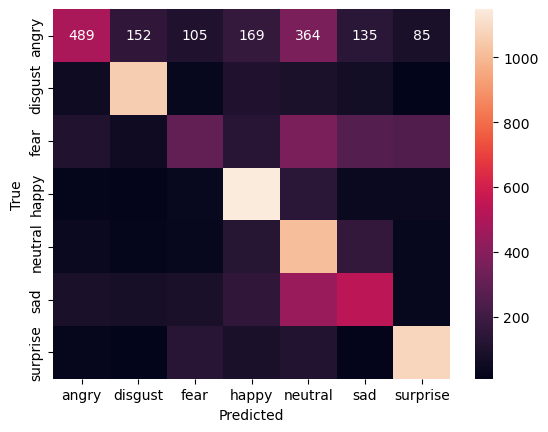

              precision    recall  f1-score   support

       angry       0.60      0.33      0.42      1499
     disgust       0.76      0.75      0.76      1408
        fear       0.42      0.20      0.27      1460
       happy       0.60      0.80      0.69      1431
     neutral       0.40      0.71      0.51      1426
         sad       0.44      0.38      0.41      1416
    surprise       0.71      0.74      0.72      1461

    accuracy                           0.56     10101
   macro avg       0.56      0.56      0.54     10101
weighted avg       0.56      0.56      0.54     10101



In [12]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=emotion_labels))


In [19]:
model.save("emotion_recognition_model.h5")